### Import libraries & data

In [1]:
# import libraries
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# read test and train data, print shapes
test = pd.read_csv('datasets/test.csv', index_col=0)
train = pd.read_csv('datasets/train.csv', index_col=0)
train.shape, test.shape

((2051, 80), (878, 79))

In [3]:
test['SalePrice'] = np.nan      # align test data with empty SalePrice column
train['dataset'] = 0            # ID train data with dataset col = 0
test['dataset'] = 1             # ID test data with dataset col = 0
df = pd.concat([test, train])   # concatenate

### Fill missing values

In [4]:
# iterate through columns will Na values
for col in [c for c in df.columns if df[c].isna().sum() > 0]:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna("None")  # fill na with 'none' in object columns
    else:
        df[col] = df[col].fillna(0)       # fill na with 0 in numerical columns

### Encode ordinal categories

In [5]:
# map over ordinals with standard scale:
standard_mapper =  {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None':0}
standard_cols = ['Exter Qual', 'Exter Cond', 'Bsmt Cond', 'Bsmt Qual',
               'Heating QC', 'Kitchen Qual', 'Fireplace Qu', 'Garage Qual',
               'Garage Cond', 'Pool QC']
for col in standard_cols:
    df[col] = df[col].replace(standard_mapper).astype('float')

In [6]:
# map over basement ordinals:
bsmtft_mapper =  { 'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6, }
bsmt_fincols = ['BsmtFin Type 1', 'BsmtFin Type 2']
for col in bsmt_fincols:
    df[col] = df[col].replace(bsmtft_mapper).astype('float')

In [7]:
# map over ordinals with unique scales:
other_mapper = {
    'Lot Shape': { 'None': 0, 'Reg': 0, 'IR1': 1, 'IR2': 2, 'IR3': 3, },
    'Utilities': { 'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1, 'None': 0, },
    'Land Slope': { 'None': 0, 'Gtl': 0, 'Mod': 1, 'Sev': 2, },
    'Bsmt Exposure': { 'Gd': 5, 'Av': 3, 'Mn': 2, 'No': 0, 'None': 0, },
    'Electrical': { 'SBrkr': 4, 'FuseA': 3, 'FuseF': 2, 'FuseP': 1, 'Mix': 4, 'None': 0, },
    'Functional': { 'None': 0, 'Typ': 0, 'Min1': 2, 'Min2': 3, 'Mod': 4, 'Maj1': 6, 'Maj2': 7, 'Sev': 8, 'Sal': 10, },
    'Garage Finish': { 'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0, },
    'Paved Drive': { 'Y': 3, 'P': 2, 'N': 1, 'None': 0, },
    'Fence': { 'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'None': 0, },}
for col, mapper in other_mapper.items():
    df[col] = df[col].replace(mapper).astype('float')

#### Also convert ordinals to objects :
(so they get dummied)

In [8]:
ordinals = bsmt_fincols + standard_cols + [k for k in other_mapper.keys()] # list ordinals
df[[col+'_num' for col in ordinals]] = df[ordinals] # save numericals in new _num cols
df[ordinals] = df[ordinals].astype('str') # revert original to string to catch get_dummies
ordinals

['BsmtFin Type 1',
 'BsmtFin Type 2',
 'Exter Qual',
 'Exter Cond',
 'Bsmt Cond',
 'Bsmt Qual',
 'Heating QC',
 'Kitchen Qual',
 'Fireplace Qu',
 'Garage Qual',
 'Garage Cond',
 'Pool QC',
 'Lot Shape',
 'Utilities',
 'Land Slope',
 'Bsmt Exposure',
 'Electrical',
 'Functional',
 'Garage Finish',
 'Paved Drive',
 'Fence']

### A few custom features

In [9]:
# total porch
porches = [col for col in df.columns if 'porch' in col.lower()]
df['Total Porch'] = 0
for col in porches:
    df['porch_sum'] = df['Total Porch'] + df[col]

In [10]:
# total SF
df['Total SF'] = df['Gr Liv Area'] + df['Total Bsmt SF'] + df['Total Porch'] + df['Garage Area']

In [11]:
# total baths
df['total baths'] = df['Bsmt Full Bath'] + df['Full Bath'] + 2*df['Bsmt Half Bath'] + 2*df['Half Bath']

In [12]:
# avg room size

df['avgroomsize'] = df['Total SF'] = df['TotRms AbvGrd']

### Feature interactions

In [13]:
# BE INTELLIGENT HERE

df['Total SF*Overall Qual'] = df['Total SF']*df['Overall Qual']
df['Garage Cars*Overall Qual'] = df['Garage Cars']*df['Overall Qual']
df['Total Bsmt SF*Overall Qual'] = df['Total Bsmt SF']*df['Overall Qual']
df['1st Flr SF*Overall Qual'] = df['1st Flr SF']*df['Overall Qual']
df['Year Built*Overall Qual'] = df['Year Built']*df['Overall Qual']
df['Full Bath*Overall Qual'] = df['Full Bath']*df['Overall Qual']
df['Garage Area*Overall Qual'] = df['Garage Area']*df['Overall Qual']
df['Fireplaces*Overall Qual'] = df['Fireplaces']*df['Overall Qual']

df['Gr Liv Area*Garage Cars'] = df['Gr Liv Area']*df['Garage Cars']
df['Full Bath*Garage Cars'] = df['Gr Liv Area']*df['Garage Cars']



### Convert specific numericals to categorical
(and save numeric versions)

In [14]:
# We want these numerical features to get dummified
categoricals = ['Yr Sold', 'MS SubClass', 'Overall Qual', 'Overall Cond', 'Full Bath', 'Half Bath',
 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Type']
df[[col+'_num' for col in categoricals]] = df[categoricals]
df[categoricals] = df[categoricals].astype('str')

In [15]:
# exploiting seasonality | credit to https://jackdry.com/house-prices-advanced-regression-techniques-kaggle
df["SinMoSold"] = np.sin(2 * np.pi * df["Mo Sold"] / 12)
df["CosMoSold"] = np.cos(2 * np.pi * df["Mo Sold"] / 12)
df = df.drop("Mo Sold", axis=1)

### Dummies for big zeros

In [16]:
zeros = [col for col in df.columns if
         len(df[df[col] == 0]) > 0 and '_' not in col and 'Price' not in col]
zeros.remove('dataset')
print('{} columns have zeros.'.format(len(zeros)))

28 columns have zeros.


In [17]:
# create dummy columns to identify zero values 
for col in zeros :   
    df[col+'_is_zero'] = np.where(df[col] == 0, 1, 0)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

### Get Dummies

In [18]:
df = pd.get_dummies(df, drop_first=True)

### Log transform key X variables

In [19]:
x_to_log = [ 'Lot Area', 'Year Built', 'Year Remod/Add', 'Total SF', 'Gr Liv Area',
            '1st Flr SF', 'Total SF*Overall Qual', 'total baths', ]
for target in x_to_log:
    df[target] = df[target].apply(np.log)


---
# Modeling

### Recover train and test

In [20]:
X_train = df[df['dataset'] == 0]
X_test = df[df['dataset'] == 1]
X_train.drop(columns='dataset', inplace=True)
X_test.drop(columns='dataset', inplace=True)

/Users/jfitz/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [21]:
y_train = X_train['SalePrice']
X_train = X_train[X_train._get_numeric_data().drop(columns='SalePrice').columns]
X_test = X_test[X_test._get_numeric_data().drop(columns='SalePrice').columns]

#### Log transform

In [47]:
y_train_log = y_train.apply(np.log)

In [48]:
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

In [49]:
model = LinearRegression()
model_log = LinearRegression()
cross_val_score(model, X_train, y_train_log, cv=5).mean()

0.8097674114163282

In [50]:
model.fit(X_train, y_train_log)
model_log.fit(X_train, y_train_log)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [51]:
model.fit(X_train, y_train_log)
y_pred_log = np.exp(model.predict(X_train))

In [52]:
resids = y_train - y_pred
resids = y_train - y_pred

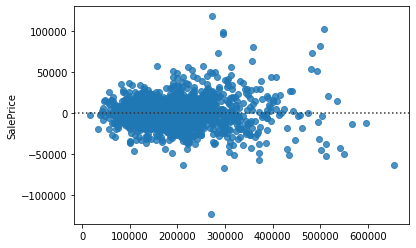

In [53]:
sns.residplot(y_pred, y_train)

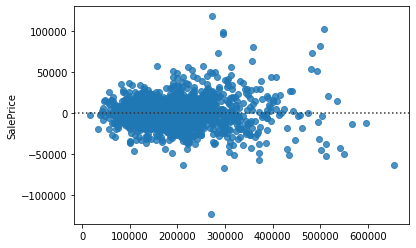

In [54]:
sns.residplot(y_pred, resids)

In [55]:
X_test.reset_index(inplace=True)

In [ ]:
# create output df
output = pd.DataFrame( {'Id': X_test['Id']} )
output['SalePrice'] = y_pred

output.head()

In [ ]:
#output.to_csv('submissions/submission_30.csv', index=False)